In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
url = 'https://raw.githubusercontent.com/brewing-datacup/reto-mexico-2020/main/data/ubicaciones.csv'
df = pd.read_csv(url, error_bad_lines=False)
dfbase = df
df.head(10)

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon
0,1,A1,1,2.0,20.506052,-98.212377
1,2,A1,1,17.0,20.458128,-98.221248
2,3,A1,1,2.0,20.530427,-98.236860
3,4,A1,3,15.0,20.488655,-98.202940
4,5,A1,1,2.0,20.533253,-98.219669
5,6,A1,1,19.0,20.531060,-98.182642
6,7,A1,1,6.0,20.594012,-98.187500
7,8,A1,1,20.0,20.489329,-98.166364
8,9,A1,1,15.0,20.575100,-98.228100
9,10,A1,1,10.0,20.580700,-98.269400


In [3]:
df.columns = df.columns.str.strip()

In [4]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print('')

Id_Cliente
False    3625
Name: Id_Cliente, dtype: int64

id_Agencia
False    3625
Name: id_Agencia, dtype: int64

Frecuencia
False    3625
Name: Frecuencia, dtype: int64

Vol_Entrega
False    3625
Name: Vol_Entrega, dtype: int64

lat
False    3625
Name: lat, dtype: int64

lon
False    3625
Name: lon, dtype: int64



In [5]:
df['Frecuencia'].value_counts()

1    3299
2     300
3      26
Name: Frecuencia, dtype: int64

In [6]:
dfbase['lat'].value_counts()

20.541500    4
20.499200    4
20.482500    4
20.531400    3
20.528200    3
            ..
20.513097    1
20.484452    1
20.502200    1
20.529384    1
20.500000    1
Name: lat, Length: 3461, dtype: int64

In [7]:
dfbase['lon'].value_counts()


-98.127800    6
-98.136300    5
-98.159200    4
-98.132800    4
-98.168600    4
             ..
-98.178743    1
-98.200834    1
-98.237118    1
-98.223645    1
-98.146077    1
Name: lon, Length: 3440, dtype: int64

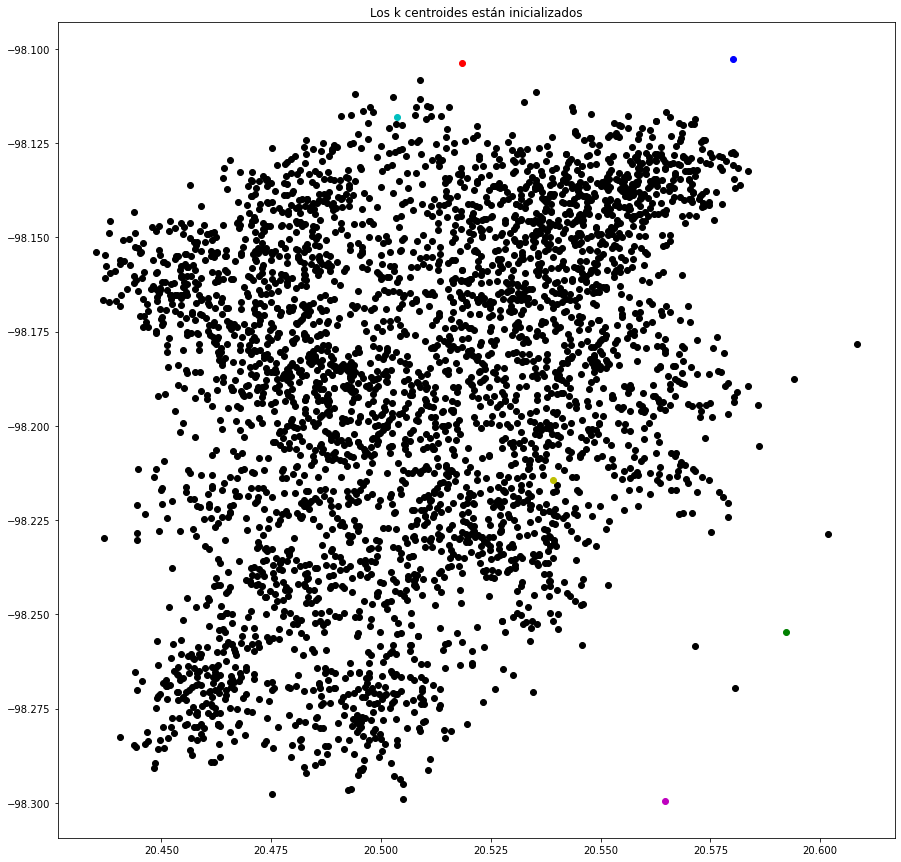

In [8]:
## Inicialización
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
df = pd.DataFrame({
    'x1': dfbase['lat'],
    'x2': dfbase['lon']
})
 
np.random.seed(200)
# Número de centroides k = 3
k = 6
# Inicializamos los centroides a valores aleatorios en el espacio de datos
centroids = {
    i+1: [np.random.uniform(20.45, 20.60), np.random.uniform(-98.30,-98.10)]
    for i in range(k)
}
     
fig = plt.figure(figsize=(15, 15))
plt.scatter(df['x1'], df['x2'], color='k')
colmap = {1: 'g', 2: 'y', 3: 'm', 4: 'c' , 5: 'r', 6: 'b' }
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.title(u'Los k centroides están inicializados')
plt.show()

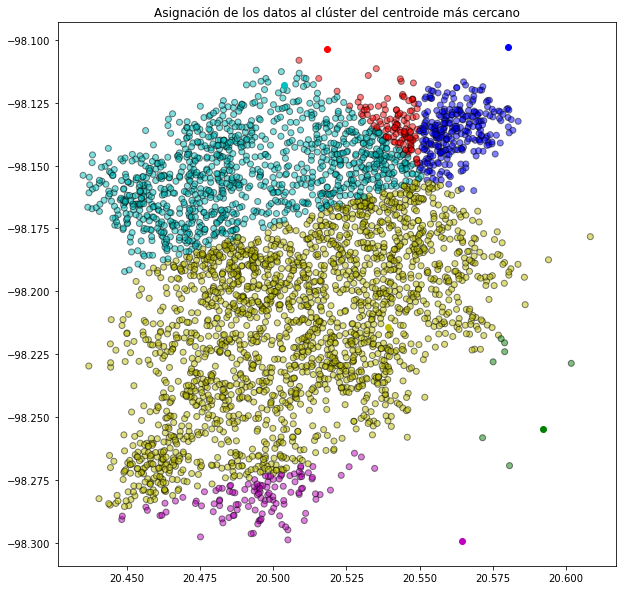

In [9]:
## Asignación de las observaciones a los centroides
 
def asignacion(df, centroids):
    for i in centroids.keys():
        # sqrt((x1 - c1)^2 - (x2 - c2)^2)
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['x1'] - centroids[i][0]) ** 2
                + (df['x2'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df
 
df = asignacion(df, centroids)
 
fig = plt.figure(figsize=(10, 10))
plt.scatter(df['x1'], df['x2'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.title(u'Asignación de los datos al clúster del centroide más cercano')
plt.show()


In [10]:
## Actualización de los centroides
def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['x1'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['x2'])
    return k

def updateCentroides(centroids):
    centroids = update(centroids)

In [11]:
def asignaCentroide(df,centroids):
  df = asignacion(df, centroids)
 
def ploteaCentroides(df,centroids):
  # Representación de resultados
  fig = plt.figure(figsize=(10, 10))
  plt.scatter(df['x1'], df['x2'], color=df['color'], alpha=0.5, edgecolor='k')
  for i in centroids.keys():
      plt.scatter(*centroids[i], color=colmap[i])
  plt.title(u'Repetición de la asignación de las observaciones al centroide más cercano')
  plt.show()


In [12]:
dfclusters = df.copy()
dfclusters['closest'].replace({1:"A", 
                      2:"B",
                      3:"C", 
                      4:"D", 
                      5:"E", 
                      6:"F"}, inplace=True)

In [13]:
dfclusters.head(1)

,x1,x2,distance_from_1,distance_from_2,distance_from_3,distance_from_4,distance_from_5,distance_from_6,closest,color
0,20.506052,-98.212377,0.095929,0.033169,0.10492,0.094347,0.109438,0.132257,B,y


In [14]:
def balVol(dfclusters):
  total = dfbase['Frecuencia'] * dfbase['Vol_Entrega']
  dfVolcluster = pd.DataFrame({'Vol_Total':total ,'cluster': dfclusters['closest']})
  df_aux = dfVolcluster.groupby(['cluster']).sum()
  totalVol = np.array(df_aux['Vol_Total'])
  return totalVol


In [15]:
totalCliente = dfclusters['closest'].value_counts()
dfclusters.head(1)
volumenCluster = balVol(dfclusters)

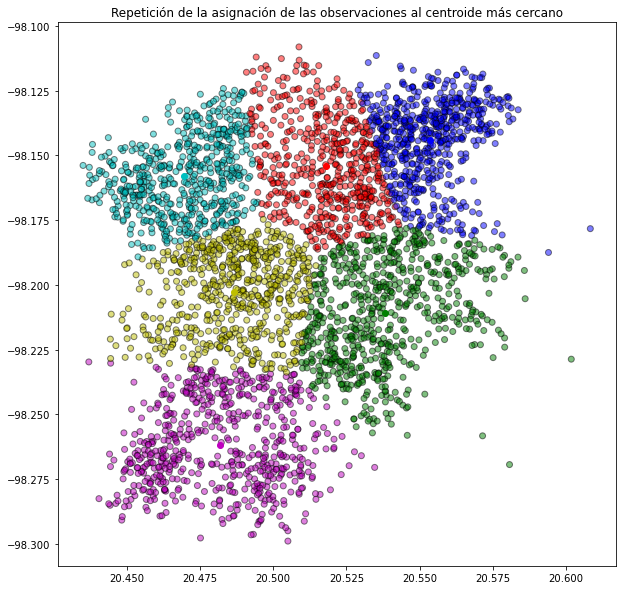

1    671
6    616
3    612
2    608
4    580
5    538
Name: closest, dtype: int64
[ 8656.         11677.          9428.99999998  9488.
  7834.          7316.00000001]


In [16]:
totalCliente = dfclusters['closest'].value_counts()
volumenCluster = balVol(dfclusters)
iter=0
while (abs(totalCliente.any() - 604) > 0 )and (abs(volumenCluster.any() - 9067) > 0) :
  dfclusters.head(1)
  updateCentroides(centroids)
  asignaCentroide(df,centroids)
  totalCliente = df['closest'].value_counts()
  dfclusters['closest'] = df['closest']
  volumenCluster = balVol(df)
  
  iter = iter + 1
  if iter > 200:
    break
ploteaCentroides(df, centroids)
print(totalCliente)
print(volumenCluster) 
         

In [17]:
dfclusters.head(5)

,x1,x2,distance_from_1,distance_from_2,distance_from_3,distance_from_4,distance_from_5,distance_from_6,closest,color
0,20.506052,-98.212377,0.095929,0.033169,0.104920,0.094347,0.109438,0.132257,2,y
1,20.458128,-98.221248,0.138126,0.081329,0.132109,0.112767,0.132159,0.170027,2,y
2,20.530427,-98.236860,0.064242,0.024157,0.071302,0.121787,0.133761,0.142973,1,y
3,20.488655,-98.202940,0.115708,0.051778,0.122804,0.086187,0.103663,0.135617,2,y
4,20.533253,-98.219669,0.068518,0.007959,0.085706,0.105843,0.116975,0.125915,1,y


In [18]:
distancias = pd.DataFrame({'Id_cliente': dfbase['Id_Cliente'],
                          'distancia1':dfclusters['distance_from_1'],
                          'distancia2':dfclusters['distance_from_2'],
                          'distancia3':dfclusters['distance_from_3'],
                          'distancia4':dfclusters['distance_from_4'],
                          'distancia5':dfclusters['distance_from_5'],
                          'distancia6':dfclusters['distance_from_6'],
                         })
distancias.head(5)

,Id_cliente,distancia1,distancia2,distancia3,distancia4,distancia5,distancia6
0,1,0.095929,0.033169,0.104920,0.094347,0.109438,0.132257
1,2,0.138126,0.081329,0.132109,0.112767,0.132159,0.170027
2,3,0.064242,0.024157,0.071302,0.121787,0.133761,0.142973
3,4,0.115708,0.051778,0.122804,0.086187,0.103663,0.135617
4,5,0.068518,0.007959,0.085706,0.105843,0.116975,0.125915


In [19]:
distancias.iloc[0,3] # Primera columna


0.10491994959342889

In [20]:
lista , listaordenada =  [] , []
for i in dfbase.index: 
  lista.append(distancias.iloc[0,1])
  lista.append(distancias.iloc[0,2]) 
  lista.append(distancias.iloc[0,3])
  lista.append(distancias.iloc[0,4])
  lista.append(distancias.iloc[0,5])
  lista.append(distancias.iloc[0,6])
  listaordenada = lista.copy()
  listaordenada.sort()
  break
print(lista)



[0.0959291950497434, 0.0331690564817748, 0.10491994959342889, 0.09434749371456935, 0.10943777345001009, 0.13225716105947896]


In [21]:
def buscarIdice(valor,lista):
  for j in range(0,5):
    if valor == lista[j]:
      return j


In [23]:
dfclusters['closest'].replace({1:"A", 
                      2:"B",
                      3:"C", 
                      4:"D", 
                      5:"E", 
                      6:"F"}, inplace=True)

In [24]:
clusters = pd.DataFrame({'Id_Cliente':dfbase['Id_Cliente'],
                         'Frecuencia':dfbase['Frecuencia'],
                         'Vol_Entrega':dfbase['Vol_Entrega'] ,
                         'cluster': dfclusters['closest']})
clusters

,Id_Cliente,Frecuencia,Vol_Entrega,cluster
0,1,1,2.0,B
1,2,1,17.0,B
2,3,1,2.0,A
3,4,3,15.0,B
4,5,1,2.0,A
...,...,...,...,...
3620,3621,1,15.0,F
3621,3622,1,2.0,F
3622,3623,1,6.0,E
3623,3624,1,31.0,E


In [25]:
clusters['cluster'].unique()

array(['B', 'A', 'F', 'D', 'E', 'C'], dtype=object)

In [26]:
clusters = pd.DataFrame({'Id_Cliente':dfbase['Id_Cliente'],'cluster':dfclusters['closest']})
clusters['cluster'].value_counts()

A    671
F    616
C    612
B    608
D    580
E    538
Name: cluster, dtype: int64

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
ohe = OneHotEncoder(sparse = False)
le = LabelEncoder()
df = ohe.fit_transform(le.fit_transform(dfclusters['closest']).reshape(-1, 1))
df = pd.DataFrame(df)
df.astype(int)

,0,1,2,3,4,5
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
3620,0,0,0,0,0,1
3621,0,0,0,0,0,1
3622,0,0,0,0,1,0
3623,0,0,0,0,1,0


In [28]:
df.columns

RangeIndex(start=0, stop=6, step=1)

In [29]:
output = pd.DataFrame({'Id_Cliente': dfbase['Id_Cliente'],
                       'D1': df[0].astype(int),
                       'D2': df[1].astype(int),
                       'D3': df[2].astype(int),
                       'D4': df[3].astype(int),
                       'D5': df[4].astype(int),
                       'D6': df[5].astype(int)})
output

,Id_Cliente,D1,D2,D3,D4,D5,D6
0,1,0,1,0,0,0,0
1,2,0,1,0,0,0,0
2,3,1,0,0,0,0,0
3,4,0,1,0,0,0,0
4,5,1,0,0,0,0,0
...,...,...,...,...,...,...,...
3620,3621,0,0,0,0,0,1
3621,3622,0,0,0,0,0,1
3622,3623,0,0,0,0,1,0
3623,3624,0,0,0,0,1,0


In [31]:
frec2 , frec3 = 0 , 0 

posicion = 0

for i in dfbase.index: 
     
  if dfbase["Frecuencia"][i] == 2:
    valor = listaordenada[1]
    posicion = buscarIdice(valor,lista)
    output.iloc[i,posicion+1]=1

    frec2 = frec2 + 1
  if dfbase["Frecuencia"][i] == 3:
    valor1 = listaordenada[1]
    posicion1 = buscarIdice(valor1,lista)
    output.iloc[i,posicion1+1]=1
    valor2 = listaordenada[2]
    posicion2 = buscarIdice(valor2,lista)
    output.iloc[i,posicion2+1]=1
    

    #lista = np.array(distancias['distancia1','distancia2','distancia3','distancia4','distancia5','distancia6'][i])
    frec2 = frec2 + 1

output

,Id_Cliente,D1,D2,D3,D4,D5,D6
0,1,0,1,0,0,0,0
1,2,0,1,0,0,0,0
2,3,1,0,0,0,0,0
3,4,1,1,0,1,0,0
4,5,1,0,0,0,0,0
...,...,...,...,...,...,...,...
3620,3621,0,0,0,0,0,1
3621,3622,0,0,0,0,0,1
3622,3623,0,0,0,0,1,0
3623,3624,0,0,0,0,1,0


In [35]:
output.to_csv('outputreq.csv',sep=',', index=False) 